In [1]:
# This notebook fits an initial model at alpha0
# then it refits alternative models for different alpha's

In [2]:
git_repo = '../../../../'

import sys
import os
import warnings

sys.path.insert(0, os.path.join(git_repo, 'BNP_sensitivity/GMM_clustering/'))
sys.path.insert(0, '../../../../LinearResponseVariationalBayes.py')

# Linear response libraries
import LinearResponseVariationalBayes as vb
import LinearResponseVariationalBayes.SparseObjectives as obj_lib

# My libraries
import gmm_clustering_lib as gmm_utils
import modeling_lib 
import functional_sensitivity_lib as fun_sens_lib 
import utils_lib
import simulation_lib

from scipy import spatial
import scipy.cluster.hierarchy as sch

import matplotlib.pyplot as plt
%matplotlib inline

import time
from tqdm import tqdm

from copy import deepcopy

import numpy as np
import scipy as sp

np.random.seed(453453)

import json 

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import warnings

In [3]:
# colors for plotting
import matplotlib.cm as cm

cmap = cm.get_cmap(name='gist_rainbow')
colors1 = [cmap(k * 50) for k in range(12)]
colors2 = [cmap(k * 25) for k in range(12)]

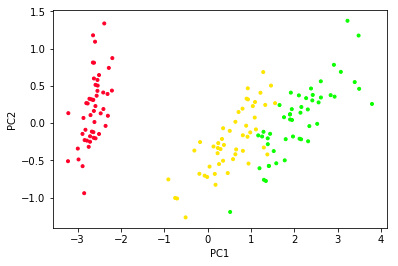

In [4]:
# load (or simulate) data
simulate = False
if not simulate:
    # load iris data
    dataset_name = 'iris'
    features, iris_species = utils_lib.load_data()
    dim = features.shape[1]
    
    # run PCA
    pca_fit = PCA()
    pca_fit.fit(features)
    pc_features = pca_fit.transform(features)
    
    # plot
    fig1 = plt.figure(1)
    fig = fig1.add_subplot(111)
    utils_lib.plot_clusters(pc_features[:, 0], pc_features[:, 1], iris_species, colors1, fig)
    fig.set_xlabel('PC1')
    fig.set_ylabel('PC2')
    
    
else:
    # Simulate data
    dataset_name = 'simulation'

    n_obs = 1000
    dim = 2
    true_k = 3
    features, true_z, true_components, true_centroids, true_covs, true_probs = \
        simulation_lib.simulate_data(n_obs, dim, true_k, separation=0.4)

    for k in range(true_k):
        plt.plot(features[true_components == k, 0], features[true_components == k, 1], '.')

# Set up the model

In [5]:
prior_params = gmm_utils.get_default_prior_params(dim)
prior_params['alpha'].set(3.5)

prior_params['prior_gamma_df'].set(8)
prior_params['prior_gamma_inv_scale'].set(np.eye(dim) * 0.62)

In [6]:
k_approx = 30
gh_deg = 8
model = gmm_utils.DPGaussianMixture(
    features, k_approx, prior_params, gh_deg, use_logitnormal_sticks=True)

In [7]:
# run k-means init
n_kmeans_init = 50
kmeans_init_global_free_param = model.cluster_and_set_inits(n_kmeans_init = n_kmeans_init)

In [8]:
t0 = time.time()
best_param, converged, x_conv, f_conv, grad_conv, obj_opt, opt_results = \
    model.optimize_full(kmeans_init_global_free_param)
t_newton = time.time() - t0

assert converged
print('Done. Converged: ', converged)

Iter: 0	 RMSE: 12.249836591872096	 Objective: 450.9718947107098
Iter: 1	 RMSE: 11.436312404325731	 Objective: 288.4225294829845
Iter: 2	 RMSE: 10.940889268755464	 Objective: 132.82724909845854
Iter: 3	 RMSE: 10.248511374397198	 Objective: 849.6952233810521
Iter: 4	 RMSE: 11.138089576834677	 Objective: 102.95800123641853
Iter: 5	 RMSE: 10.96622863463417	 Objective: 69.15077894918426
Iter: 6	 RMSE: 10.395649824022767	 Objective: 35.105982797242774
Iter: 7	 RMSE: 9.688581522726356	 Objective: 149.86270237169427
Iter: 8	 RMSE: 10.288654783440967	 Objective: 27.908100146753185
Iter: 9	 RMSE: 10.042395644739976	 Objective: 15.665326762573898
Iter: 10	 RMSE: 9.795264337293531	 Objective: -4.960377570510673
Iter: 11	 RMSE: 9.428651128235872	 Objective: -35.632424732389836
Iter: 12	 RMSE: 9.339252138943369	 Objective: -69.57876702499088
Iter: 13	 RMSE: 8.93648414065044	 Objective: -106.48627732345867
Iter: 14	 RMSE: 8.802905984330774	 Objective: -109.56137217514271
Iter: 15	 RMSE: 8.77974024371

In [9]:
kl_hessian = model.objective.fun_free_hessian(best_param)

In [10]:
# look at results
bnp_clusters = np.argmax(model.e_z, axis = 1)
bnp_centroids = model.vb_params['global']['centroids'].get()

bnp_cluster_infos = model.vb_params['global']['gamma'].get()
bnp_cluster_covs = np.linalg.inv(bnp_cluster_infos)

In [11]:
# we plot in PCA space
bnp_centroids_pc, bnp_cluster_covs_pc = \
    utils_lib.transform_params_to_pc_space(pca_fit, bnp_centroids, bnp_cluster_covs)

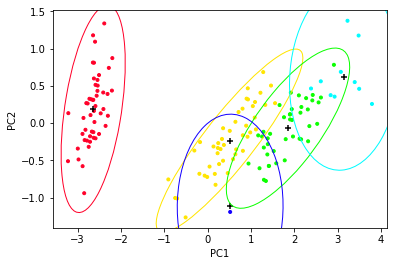

In [12]:
# plot results

fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

colors1_ = deepcopy(colors1)
# colors1_[0] = colors1[2]
# colors1_[1] = colors1[0]
# colors1_[2] = colors1[1]

utils_lib.plot_clusters(pc_features[:, 0], pc_features[:, 1], bnp_clusters, \
              colors1_, fig, \
              centroids = bnp_centroids_pc[:, np.unique(bnp_clusters)], \
              cov = bnp_cluster_covs_pc[np.unique(bnp_clusters)])

fig.set_xlabel('PC1')
fig.set_ylabel('PC2')

In [13]:
logit_stick_lengths = model.global_vb_params['v_sticks']['mean'].get()
stick_lengths = sp.special.expit(logit_stick_lengths)
modeling_lib.get_mixture_weights(stick_lengths)
  


array([3.28998226e-01, 3.05446135e-01, 2.69750528e-01, 5.58446237e-03,
       7.04498531e-03, 5.75325952e-02, 7.12430287e-03, 3.52881368e-03,
       2.74042527e-03, 2.16478178e-03, 1.73720544e-03, 1.41335189e-03,
       1.16217614e-03, 9.62063332e-04, 7.99218371e-04, 6.65193137e-04,
       5.54236517e-04, 4.62081479e-04, 3.85400690e-04, 3.21525528e-04,
       2.68281262e-04, 2.23879268e-04, 1.86840514e-04, 1.55937973e-04,
       1.30151622e-04, 1.08632416e-04, 9.06730290e-05, 7.56838595e-05,
       6.31732420e-05, 3.19038567e-04])

In [14]:
model.global_vb_params.set_free(best_param)
model.set_optimal_z()

class_weights = np.sum(model.e_z, axis=0) / model.n_obs
if class_weights[-1] > 1/k_approx: 
    warnings.warn('last cluster may not be unoccopied')

print(class_weights)
print(gmm_utils.get_e_num_clusters_from_free_par(best_param, model))

e_z = model.e_z
k = np.shape(e_z)[1]
print(k - np.sum(np.prod(1 - e_z, axis = 0)))

print(k)
print(np.prod(1 - e_z, axis = 0).shape)

[3.33333268e-01 3.10758162e-01 2.76550554e-01 2.14562816e-03
 4.10520004e-03 6.34603488e-02 5.59806255e-03 1.46441083e-03
 9.53710340e-04 6.02885241e-04 3.69884736e-04 2.23668126e-04
 1.38006201e-04 8.89972933e-05 5.95569273e-05 4.09640017e-05
 2.87602664e-05 2.05056808e-05 1.47895977e-05 1.07587303e-05
 7.87647777e-06 5.79371407e-06 4.27669337e-06 3.16513914e-06
 2.34704649e-06 1.74291583e-06 1.29568295e-06 9.63981822e-07
 7.17625683e-07 3.69931967e-06]
6.121167457502192
6.121167457502192
30
(30,)


In [15]:
# save model

fit_dict = gmm_utils.get_checkpoint_dictionary(model, kl_hessian, seed=453453)
base_alpha = model.prior_params['alpha'].get()
filename = 'bnp_full_data_fit_alpha{}_{}.json'.format(base_alpha, dataset_name)
json_output_file = os.path.join(
    './iris_fits_for_nips/',
    filename)
print('saving fit dict to ', json_output_file)
with open(json_output_file, 'w') as outfile:
    json.dump(fit_dict, outfile)


saving fit dict to  ./iris_fits_for_nips/bnp_full_data_fit_alpha3.5_iris.json


# Fit multiple models and save them: 

In [16]:
# we use the original model as an initialization and refit for a range of alphas

In [17]:
alpha_vec = np.arange(start=0.5, stop=16, step=0.5)
# alpha_vec = np.array([1.0])
print(alpha_vec)

[ 0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5  7.
  7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5 14.
 14.5 15.  15.5]


In [18]:
for i in range(len(alpha_vec)): 
    print('\n\nRunning for alpha={}'.format(alpha_vec[i]))
       
    # define prior
    prior_params = gmm_utils.get_default_prior_params(dim)
    prior_params['alpha'].set(alpha_vec[i])

    prior_params['prior_gamma_df'].set(8)
    prior_params['prior_gamma_inv_scale'].set(np.eye(dim) * 0.62)

    # define model 
    k_approx = model.k_approx
    gh_deg = 8
    model_refit = gmm_utils.DPGaussianMixture(
        features, k_approx, prior_params, gh_deg, use_logitnormal_sticks=True)

    # initialize from the original model 
    init_global_free_param = deepcopy(best_param)
    
    # ...or from kmeans (this gives really erratic results)
    #init_global_free_param = deepcopy(kmeans_init_global_free_param)
    
    # fit model
    t0 = time.time()
    best_param_refit, converged, x_conv, f_conv, grad_conv, obj_opt, opt_results = \
        model_refit.optimize_full(init_global_free_param)
    t_newton = time.time() - t0
    
    model_refit.global_vb_params.set_free(best_param_refit)
    model_refit.set_optimal_z()
    class_weights = np.sum(model.e_z, axis=0) / model.n_obs
    
    if class_weights[-1] > 1/k_approx: 
        warnings.warn('last cluster may not be unoccopied')

    assert converged
    print('Done. Converged: ', converged)

    # get KL
    kl_hessian = model_refit.objective.fun_free_hessian(best_param_refit)

    # save model
    fit_dict = gmm_utils.get_checkpoint_dictionary(model_refit, kl_hessian, seed=453453)
    alpha = model_refit.prior_params['alpha'].get()
    filename = 'bnp_full_data_fit_alpha{}_{}.json'.format(alpha, dataset_name)
    json_output_file = os.path.join(
        './iris_fits_for_nips/',
        filename)
    print('saving fit dict to ', json_output_file)
    with open(json_output_file, 'w') as outfile:
        json.dump(fit_dict, outfile)




Running for alpha=0.5
Iter: 0	 RMSE: 7.761038595668291	 Objective: -403.98026660683803
Iter: 1	 RMSE: 7.819218911535391	 Objective: -406.5876825544169
Iter: 2	 RMSE: 8.075449353065112	 Objective: -373.3465344734436
Iter: 3	 RMSE: 7.8221538330644	 Objective: -406.7711118143222
Iter: 4	 RMSE: 7.8273978992097755	 Objective: -407.08966802069244
Iter: 5	 RMSE: 7.841014079338213	 Objective: -407.69240997790286
Iter: 6	 RMSE: 7.858850066515973	 Objective: -408.45921208805123
Iter: 7	 RMSE: 7.874172431211701	 Objective: -409.1920364124764
Iter: 8	 RMSE: 7.8933724910479315	 Objective: -409.7321386687745
Iter: 9	 RMSE: 7.90617865928642	 Objective: -410.38225088452896
Iter: 10	 RMSE: 7.9098561055734375	 Objective: -411.11549113135595
Iter: 11	 RMSE: 7.9319929820932185	 Objective: -412.1585474068153
Iter: 12	 RMSE: 7.951002404527529	 Objective: -413.4002782344422
Iter: 13	 RMSE: 7.976880647096937	 Objective: -413.5688900629806
Iter: 14	 RMSE: 7.9803535761543465	 Objective: -413.89839896257973
It

../../../../BNP_sensitivity/GMM_clustering/gmm_clustering_lib.py:556: UserWarning: last cluster may not be un-occupied
  warnings.warn('last cluster may not be un-occupied')


saving fit dict to  ./iris_fits_for_nips/bnp_full_data_fit_alpha15.5_iris.json


In [19]:
print('Done.')

Done.
